In [1]:
DATA_PATH = 'data/aclImdb_v1/aclImdb'
DATA_ROOT = 'data/'
CLASSIFIER_ROOT = 'classifiers/'
LABELS = {'pos': 'positive', 'neg': 'negative'}

In [15]:
import os
import re
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nlp = spacy.load('en', disable=['parser'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
np.random.seed(1)

# Reading Data and Split in Train and Test

In [3]:
# Read data
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for directory in ('test', 'train'):
    for sentiment in ('pos', 'neg'):
        path ='{0}/{1}/{2}'.format(DATA_PATH, directory, sentiment)
        for review_file in os.listdir(path):
            with open(os.path.join(path, review_file), 'r') as input_file:
                review = input_file.read()
            if directory == 'test':
                test_df = test_df.append([[review, LABELS[sentiment]]], 
                                         ignore_index=True)
            else:
                train_df = train_df.append([[review, LABELS[sentiment]]], 
                                           ignore_index=True)

In [4]:
train_df.columns = ['review', 'sentiment']
test_df.columns = ['review', 'sentiment']
indices_train = train_df.index.tolist()
indices_test = test_df.index.tolist()
np.random.shuffle(indices_train)
np.random.shuffle(indices_test)
indices_train = np.array(indices_train)
indices_test = np.array(indices_test)
train_df = train_df.reindex(index=indices_train).dropna()
test_df = test_df.reindex(index=indices_test).dropna()
train_df['count'] = train_df['review'].apply(len)
test_df['count'] = test_df['review'].apply(len)

# Plot some simple Stats

33126741
32344810


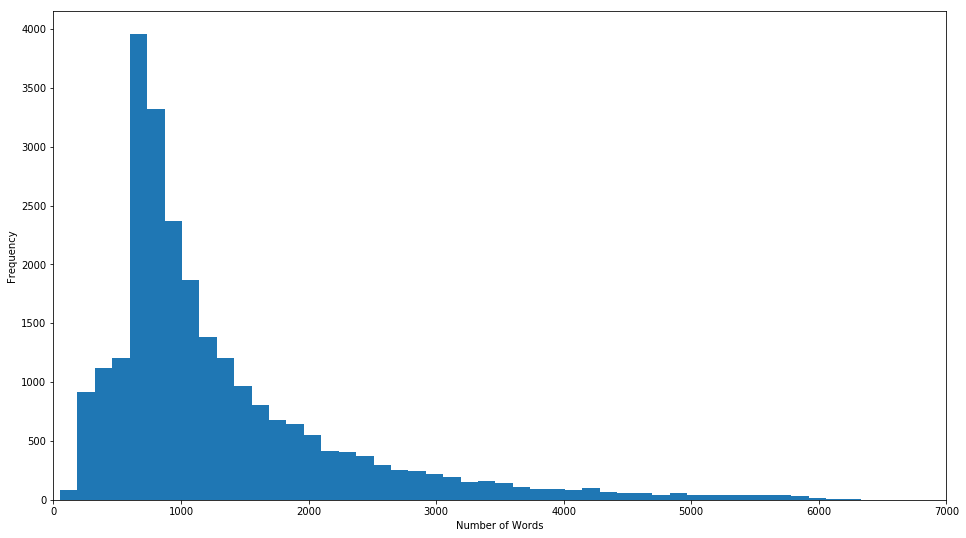

In [16]:
# Plot len stats
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 7000)
hist = plt.hist(train_df['count'], bins=100)
print(train_df['count'].sum())
print(test_df['count'].sum())

In [6]:
# Helper function to use in next steps
# A custom function to clean the text before sending it into the vectorizer
def clean_html(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext.lower()

STOP_WORDS.add("'s")
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

def lemmatization(text):
    lemma = []
    tokenized_sent = nlp(clean_html(text), disable=['parser'])
    for token in tokenized_sent:
        if not token.is_stop and not token.is_punct:
            lemma.append(token.lemma_)
    return " ".join(lemma)

In [7]:
all_lemma = []
train_df['review_lemma'] = train_df['review'].apply(lemmatization)
test_df['review_lemma'] = test_df['review'].apply(lemmatization)
train_df.replace(np.nan, '', regex=True)
test_df.replace(np.nan, '', regex=True)
word_dict = defaultdict(int)
for review in train_df['review_lemma']:
    words = review.split()
    for word in words:
        word_dict[word] += 1

{'movie': 50442, 'film': 46860, 'not': 33518, 'good': 25246, 'like': 22146, 'time': 15470, 'character': 13928, 'watch': 13607, 'bad': 13124, 'story': 12858, 'see': 12264, 'think': 11626, 'scene': 10365, 'look': 9864, 'great': 9856, 'know': 9367, 'people': 9242, 'go': 8931, 'get': 8789, 'way': 8585, 'love': 8408, 'be': 8392, 'play': 8386, 'come': 8290, 'thing': 8055, 'find': 7979, 'man': 7780, 'have': 7471, 'end': 7422, 'life': 7384}


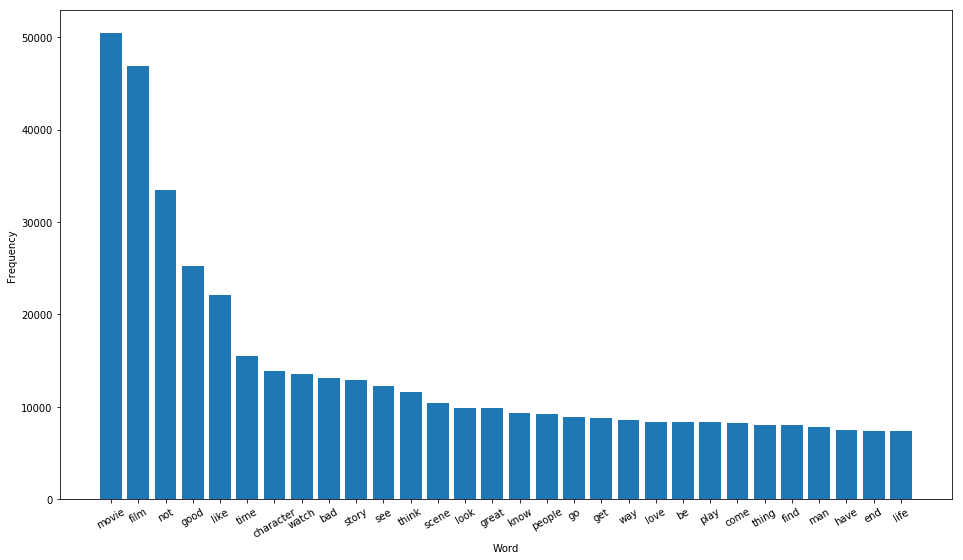

In [17]:
from collections import Counter
counts = dict(Counter(word_dict).most_common(30))
print(counts)
labels, values = zip(*counts.items())

# sort your values in descending order
ind_sort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[ind_sort]
values = np.array(values)[ind_sort]

indexes = np.arange(len(labels))

bar_width = 0.10

plt.bar(indexes, values)

# add labels
plt.xticks(indexes, labels)
plt.xticks(rotation=30)
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.show()

(-0.5, 999.5, 399.5, -0.5)

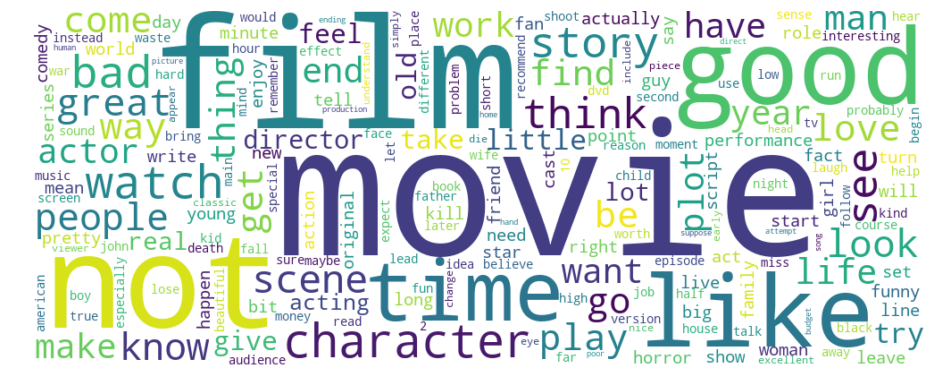

In [18]:
wordcloud = WordCloud(width=1000, height=400, background_color="white").generate_from_frequencies(Counter(word_dict))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Bag of Words

In [10]:
# Kfold Cross Validation
def k_fold_validation(classifier, X_train, Y_train, get_classifier, n_splits=10):
    acc = []
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X_train):
        X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
        Y_kf_train, Y_kf_test = Y_train[train_index], Y_train[test_index]
        # train classifier and tranform X_kf_test data
        trained_classifier, X_kf_test, _ = get_classifier(classifier, X_kf_train, Y_kf_train, X_kf_test)
        Y_predicted = trained_classifier.predict(X_kf_test)
        acc.append(accuracy_score(Y_predicted, Y_kf_test))
    return np.mean(acc)

In [11]:
# Bag of words classifier
def bag_of_words_classifier(classifier, X_train, Y_train, X_test=None):    
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    clf = classifier.fit(X_train_tfidf, Y_train)
    X_test_tfidf = None   
    if X_test is not None:
        X_test_counts = count_vect.transform(X_test)
        X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    return clf, X_test_tfidf, [count_vect, tfidf_transformer]

In [12]:
X_train = train_df['review_lemma'].values
Y_train = train_df['sentiment'].values

# Calculate CV score
clf = MultinomialNB()
nb_accuracy = k_fold_validation(clf, X_train, Y_train, bag_of_words_classifier, n_splits=10)
print("Naive Bayes Accuracy = {0}".format(nb_accuracy))

Naive Bayes Accuracy = 0.86364


In [19]:
clf = DecisionTreeClassifier(random_state=0)
dt_accuracy = k_fold_validation(clf, X_train, Y_train, bag_of_words_classifier, n_splits=10)
print("Decision Tree Accuracy = {0}".format(dt_accuracy))

Decision Tree Accuracy = 0.71288


In [20]:
# Train classifier using all train data
TRAIN_ALL_DATA = True
if TRAIN_ALL_DATA:
    clf_nb, _, transformers = bag_of_words_classifier(MultinomialNB(), X_train, Y_train)
    clf_dt, _, transformers = bag_of_words_classifier(DecisionTreeClassifier(random_state=0), X_train, Y_train)

# Persist the models
SAVE_MODEL = True
if TRAIN_ALL_DATA and SAVE_MODEL:
    pickle.dump(clf_nb, open('{0}/nb.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(clf_dt, open('{0}/dt.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(transformers[0], open('{0}/transform_bag_of_words_0.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(transformers[1], open('{0}/transform_bag_of_words_1.sav'.format(CLASSIFIER_ROOT), 'wb'))